# Solução - Parte 1: Efeitos da Regularização no Treinamento

## Objetivos:

O objetivo desse desafio é avaliar as diferenças entre os modelos treinados sem regularização e os modelos treinados com regularização do tipo L1 e do tipo L2.


## conceitos:

A regularização é uma família de técnicas utilizadas para limitar o range de valores que os parâmetros do modelo podem atingir durante o treinamento. É utilizada em problemas de otimização para buscar soluções dentro de uma limitação específica imposta ao modelo.

A regularização do tipo L1 força que, a cada iteração de treinamento, o valor de todos os parâmetros decaiam **linearmente**. A regressão do tipo L2, por outro lado, força o deacimento **quadrático** de todos os parâmetros. A figura abaixo mostra as funções aplicadas aos parâmetros:

![Funções das Regularizações L1 & L2](images/lasso_and_ridge.png)

O objetivo de ambas as regularizações é buscar soluções onde a **magnitude dos parâmetros seja a menor possível**.


___

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import os
import pandas as pd

In [3]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics.regression import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Dataset:

## Sobre o Case

### Case baseado no dataset do Kaggle: "California Housing Prices"

Esse desafio é baseado em um dataset aberto do Kaggle ([https://www.kaggle.com](https://www.kaggle.com)) de 2018, de onde é possível estimar o preço de um imóvel pertencente a uma dada região na Califórnia. 

O dataset original foi extraído do repositório StatLib, que não está mais disponível. Os dados que o compôem foram retirados do Censo realizado na Califórnia em 1990 e modificado para servir como base de treinamento.


Link para o dataset no Kaggle: [https://www.kaggle.com/harrywang/housing/data](https://www.kaggle.com/harrywang/housing/data)


### Descrição dos Dados Originais:

#### Tamanho do Dataset:

* `20.640` data points

#### Variável dependente:

* `median_house_value`:  (float) variável dependente com o valor da mediana do preço de imóvel na região

#### Features: 

* `longitude`/`latitude`: (floats) posição global da região
* `housing_median_age`: (float) mediana da idade (em anos) das casas da região
* `total_rooms`: (float) total de aposentos da região
* `total_bedrooms`: (float) total de quartos da região
* `population`: (float) população total da região
* `households`: (float) quantidade total de imóveis da região
* `median_income`: (float) mediana do salário (por hora) de uma pessoa na região
* `ocean_proximity`: (string) categorias relativas à distância do oceano


### Modificação dos dados para o Desafio:

Para tornar o desafio mais fácil de avaliar, a massa de dados original foi dividida em duas massas, uma para treino e outra para teste, ambas contendo pouco mais de `10.000` elementos. 

Por motivos didáticos, alguns elementos da massa de treino foram removidos e, sobre os elementos restantes, foi aplicada uma Feature Engineering. Não é necesário se preocupar com o que é uma Feature Engineering agora, será o tema da Aula 20. 

## Carregando os dados


### Train Dataset 

In [4]:
dataset = pd.read_csv("data/feature_engineered_california_housing_train.csv", sep="\t", index_col=0)
x_train = dataset.drop(["median_house_value"], axis=1)
y_train = dataset[["median_house_value"]]

In [5]:
print(f"shape: {x_train.shape}")
x_train.head()

shape: (10038, 88)


,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,housing_median_age,total_rooms,total_bedrooms,population,households,...,population^3,population^2 households,population^2 median_income,population households^2,population households median_income,population median_income^2,households^3,households^2 median_income,households median_income^2,median_income^3
region_id,,,,,,,,,,,,,,,,,,,,,
1,8.867709,7.008505,7.783641,7.037028,2.116424,21.0,7099.0,1106.0,2401.0,1138.0,...,1.384129e+10,6.560344e+09,4.785592e+07,3.109401e+09,2.268223e+07,165460.693946,1.473760e+09,1.075068e+07,78423.269350,572.076387
2,7.290975,5.247024,6.206576,5.176150,1.982022,52.0,1467.0,190.0,496.0,177.0,...,1.220239e+08,4.354483e+07,1.785437e+06,1.553918e+07,6.371417e+05,26124.247961,5.545233e+06,2.273671e+05,9322.564293,382.246204
4,7.394493,5.634790,6.336826,5.556828,1.347086,52.0,1627.0,280.0,565.0,259.0,...,1.803621e+08,8.267928e+07,1.227803e+06,3.790076e+07,5.628337e+05,8358.188759,1.737398e+07,2.580069e+05,3831.452900,56.897815
9,8.174421,6.561031,7.346655,6.570883,1.305952,52.0,3549.0,707.0,1551.0,714.0,...,3.731087e+09,1.717599e+09,8.879554e+06,7.906936e+08,4.087687e+06,21132.308989,3.639943e+08,1.881759e+06,9728.219612,50.292443
10,7.697121,6.073045,6.813445,5.996452,1.164119,52.0,2202.0,434.0,910.0,402.0,...,7.535710e+08,3.328962e+08,2.652487e+06,1.470596e+08,1.171758e+06,9336.463145,6.496481e+07,5.176338e+05,4124.459543,32.863324


In [6]:
print(f"shape: {y_train.shape}")
y_train.head()

shape: (10038, 1)


,median_house_value
region_id,
1,358500.0
2,352100.0
4,342200.0
9,261100.0
10,281500.0


### Test Dataset 

In [7]:
dataset = pd.read_csv("data/feature_engineered_california_housing_test.csv", sep="\t", index_col=0)
x_test = dataset.drop(["median_house_value"], axis=1)
y_test = dataset[["median_house_value"]]

In [8]:
print(f"shape: {x_test.shape}")
x_test.head()

shape: (10320, 88)


,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,housing_median_age,total_rooms,total_bedrooms,population,households,...,population^3,population^2 households,population^2 median_income,population households^2,population households median_income,population median_income^2,households^3,households^2 median_income,households median_income^2,median_income^3
region_id,,,,,,,,,,,,,,,,,,,,,
0,6.779922,4.859812,5.774552,4.836282,2.119287,41.0,880.0,129.0,322.0,126.0,...,3.338625e+07,13064184.0,8.631900e+05,5112072.0,3.377700e+05,22317.483523,2000376.0,1.321709e+05,8732.928335,577.010912
3,7.149917,5.459586,6.324359,5.389072,1.730434,52.0,1274.0,235.0,558.0,219.0,...,1.737411e+08,68188716.0,1.757058e+06,26762238.0,6.895981e+05,17769.274306,10503459.0,2.706487e+05,6973.962497,179.702136
5,6.823286,5.361292,6.023448,5.262690,1.257864,52.0,919.0,213.0,413.0,193.0,...,7.044500e+07,32919817.0,6.000447e+05,15383837.0,2.804083e+05,5111.131229,7189057.0,1.310383e+05,2388.494739,43.536195
6,7.837949,6.192362,6.997596,6.242223,1.297217,52.0,2535.0,489.0,1094.0,514.0,...,1.309339e+09,615173704.0,4.379343e+06,289030424.0,2.057570e+06,14647.580014,135796744.0,9.667196e+05,6881.952584,48.991737
7,8.040447,6.532334,7.053586,6.472346,1.137833,52.0,3104.0,687.0,1157.0,647.0,...,1.548817e+09,866105903.0,4.176585e+06,484330613.0,2.335566e+06,11262.700800,270840023.0,1.306060e+06,6298.156800,30.371328


In [9]:
print(f"shape: {y_test.shape}")
y_test.head()

shape: (10320, 1)


,median_house_value
region_id,
0,452600.0
3,341300.0
5,269700.0
6,299200.0
7,241400.0


## Normalizando Features com Z-Score

Passo importante quando se treina modelos lineares, por eliminar importâncias artificialmente grandes para features contendo valores muito grandes.

In [10]:
columns = x_train.columns

In [11]:
zscore = StandardScaler().fit(x_train.loc[:, columns])

In [12]:
x_train.loc[:, columns] = zscore.transform(x_train.loc[:, columns])
x_test.loc[:, columns] = zscore.transform(x_test.loc[:, columns])

# Problemas

## A) Treinamento e Avaliação de Modelos com e sem Regularização

A regularização tem como principal objetivo reduzir a complexidade do modelo criado ao limitar o crescimento dos parâmetros durante o treinamento. Com isso, é interessante notar que modelos com regularização tendem a ter menor diferença entre os desempenhos das métricas de avaliação sobre as massas de treino e de teste, indicando uma melhor generalização do modelo.

Nessa seção, três tipos de modelo devem ser treinados: um **sem regularização**, um com **regularização L1** e um com **regularização L2**. O desempenho dos três tipos de modelo deverá ser comparado em termos de ${MSE}$ (_Mean Squared Error_) e da medida ${R^2}$.

### Modelo s/ Regularização

##### Treinamento do modelo

Usar [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) para treinar um modelo linear sem regularização.

In [13]:
""" Escreva a solução aqui """
model = LinearRegression()
model.fit(X=x_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Avaliação do modelo treinado

Avaliar o desempenho do modelo treinado sobre as massas de **treino** de **teste** usando as funções abaixo:

* [`mean_squared_error`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
* [`r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

##### Sobre a Massa de Treino

In [14]:
""" Escreva a solução aqui """
nr_mse_tr = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))
nr_r2_tr = r2_score(y_true=y_train, y_pred=model.predict(x_train))

##### Sobre a Massa de Teste

In [15]:
""" Escreva a solução aqui """
nr_mse_te = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))
nr_r2_te = r2_score(y_true=y_test, y_pred=model.predict(x_test))

### Modelo c/ Regularização L1

##### Treinamento do modelo

Usar [Lasso Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) para treinar um modelo linear com regularização do tipo L1.

In [16]:
""" Escreva a solução aqui """
model = Lasso(alpha=1, max_iter=100, random_state=42)
model.fit(X=x_train, y=y_train)

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
   positive=False, precompute=False, random_state=42, selection='cyclic',
   tol=0.0001, warm_start=False)

#### Avaliação do modelo treinado

Avaliar o desempenho do modelo treinado sobre as massas de **treino** de **teste** usando as funções abaixo:

* [`mean_squared_error`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
* [`r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

##### Sobre a Massa de Treino

In [17]:
""" Escreva a solução aqui """
l1_mse_tr = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))
l1_r2_tr = r2_score(y_true=y_train, y_pred=model.predict(x_train))

##### Sobre a Massa de Teste

In [18]:
""" Escreva a solução aqui """
l1_mse_te = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))
l1_r2_te = r2_score(y_true=y_test, y_pred=model.predict(x_test))

### Modelo c/ Regularização L2

##### Treinamento do modelo

Usar [Ridge Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) para treinar um modelo linear com regularização do tipo L2.

In [19]:
""" Complete os espaços com ? """
model = Ridge(alpha=1, max_iter=100, random_state=42)
model.fit(X=x_train, y=y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
   random_state=42, solver='auto', tol=0.001)

#### Avaliação do modelo treinado

Avaliar o desempenho do modelo treinado sobre as massas de **treino** de **teste** usando as funções abaixo:

* [`mean_squared_error`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
* [`r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

##### Sobre a Massa de Treino

In [20]:
""" Escreva a solução aqui """
l2_mse_tr = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))
l2_r2_tr = r2_score(y_true=y_train, y_pred=model.predict(x_train))

##### Sobre a Massa de Teste

In [21]:
""" Escreva a solução aqui """
l2_mse_te = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))
l2_r2_te = r2_score(y_true=y_test, y_pred=model.predict(x_test))

### Comparação dos modelos treinados

Criar uma tabela mostrando os valores de ${MSE}$ e de ${R^2}$ para as massas de treino e teste em cada modelo treinado, da forma mostrada abaixo:

| Regularização | ${MSE}$ de Treino | ${MSE}$ de Teste | ${R^2}$ de Treino | ${R^2}$ de Teste |
|:-------------:|:-----------------:|:----------------:|:-----------------:|:----------------:|
| Nenhuma       | x.xx              | x.xx             | x.xx              | x.xx             |
| L1            | x.xx              | x.xx             | x.xx              | x.xx             |
| L2            | x.xx              | x.xx             | x.xx              | x.xx             |

In [22]:
""" Escreva a solução aqui """
pd.DataFrame(
    index=pd.Index(name="Regularização", data=["Nenhuma", "L1", "L2"]),
    columns=["MSE de Treino", "MSE de Teste", "R^2 de Treino", "R^2 de Teste"],
    data=[
        [nr_mse_tr, nr_mse_te, nr_r2_tr, nr_r2_te],
        [l1_mse_tr, l1_mse_te, l1_r2_tr, l1_r2_te],
        [l2_mse_tr, l2_mse_te, l2_r2_tr, l2_r2_te],
    ]
)

,MSE de Treino,MSE de Teste,R^2 de Treino,R^2 de Teste
Regularização,,,,
Nenhuma,4.561153e+09,2.118553e+10,0.651596,-0.598342
L1,4.782075e+09,6.918209e+09,0.634721,0.478056
L2,4.623994e+09,1.011449e+10,0.646796,0.236913


## B) Efeito do parâmetro ${alpha}$ da regularização sobre o desempenho dos modelos

O peso ${alpha}$ dado à regularização influencia o quanto o treinamento dos parâmetros é afetado. ${alpha}$ é sempre um número não negativo (i.e. ${\geq{0}}$); o caso especial em que ${alpha=0}$ é exatamente a Regressão Linear **sem regularização**.

Nessa seção, serão plotados alguns gráficos para avaliar como o ${alpha}$ influencia nas métricas da avaliação de um modelo. A comparação das métricas de avaliação das curvas de treino e de teste será feita variando ${alpha}$ e medindo o ${MSE}$ e o ${R^2}$.

### Função de Plot

In [23]:
def plot_comparison(alpha_list, mse_tr_list, mse_te_list, r2_tr_list, r2_te_list):
    # plotting graphics
    fig, (ax_mse, ax_r2) = plt.subplots(2, sharex=True, figsize=(15, 8))

    # MSE
    mse_df = pd.DataFrame(
        index=alpha_list,
        columns=["train", "test"],
        data=list(zip(mse_tr_list, mse_te_list))
    )
    mse_df.plot(title="Comparação de MSE: Treino Vs Teste", ax=ax_mse)
    ax_mse.set(xlabel="alpha", ylabel="mean squared error")

    # R2
    r2_df = pd.DataFrame(
        index=alpha_list,
        columns=["train", "test"],
        data=list(zip(r2_tr_list, r2_te_list))
    )
    r2_df.plot(title="Comparação de R^2: Treino Vs Teste", ax=ax_r2)
    ax_r2.set(xlabel="alpha", ylabel="r squared")

### Regularização L1

In [24]:
# Definição dos valores de alpha
alpha_list = np.linspace(0.001, 3000, 100)

In [25]:
# initializing lists
mse_tr_list = []
mse_te_list = []
r2_tr_list = []
r2_te_list = []

In [26]:
""" Complete os espaços com ? """
for alpha in alpha_list:
    # create / train model
    model = Lasso(alpha=alpha, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    
    # Train Evaluation Metrics
    y_true = y_train
    y_pred = model.predict(x_train)
    mse_tr = mean_squared_error(y_true=y_true, y_pred=y_pred)
    r2_tr = r2_score(y_true=y_true, y_pred=y_pred)
    
    # Test Evaluation Metrics
    y_true = y_test
    y_pred = model.predict(x_test)
    mse_te = mean_squared_error(y_true=y_true, y_pred=y_pred)
    r2_te = r2_score(y_true=y_true, y_pred=y_pred)
    
    # append all eval metrics
    mse_tr_list.append(mse_tr)
    mse_te_list.append(mse_te)
    r2_tr_list.append(r2_tr)
    r2_te_list.append(r2_te)

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


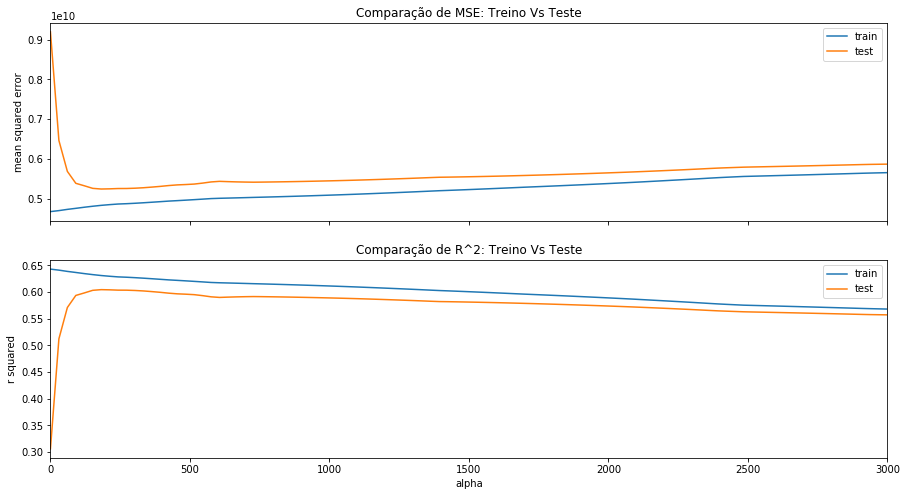

In [27]:
plot_comparison(alpha_list, mse_tr_list, mse_te_list, r2_tr_list, r2_te_list)

### Regularização L2

In [28]:
# Definição dos valores de alpha
alpha_list = np.linspace(0.001, 3000, 100)

In [29]:
# initializing lists
mse_tr_list = []
mse_te_list = []
r2_tr_list = []
r2_te_list = []

In [30]:
""" Complete os espaços com ? """
for alpha in alpha_list:
    # create / train model
    model = Ridge(alpha=alpha, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    
    # Train Evaluation Metrics
    y_true = y_train
    y_pred = model.predict(x_train)
    mse_tr = mean_squared_error(y_true=y_true, y_pred=y_pred)
    r2_tr = r2_score(y_true=y_true, y_pred=y_pred)
    
    # Test Evaluation Metrics
    y_true = y_test
    y_pred = model.predict(x_test)
    mse_te = mean_squared_error(y_true=y_true, y_pred=y_pred)
    r2_te = r2_score(y_true=y_true, y_pred=y_pred)
    
    # append all eval metrics
    mse_tr_list.append(mse_tr)
    mse_te_list.append(mse_te)
    r2_tr_list.append(r2_tr)
    r2_te_list.append(r2_te)

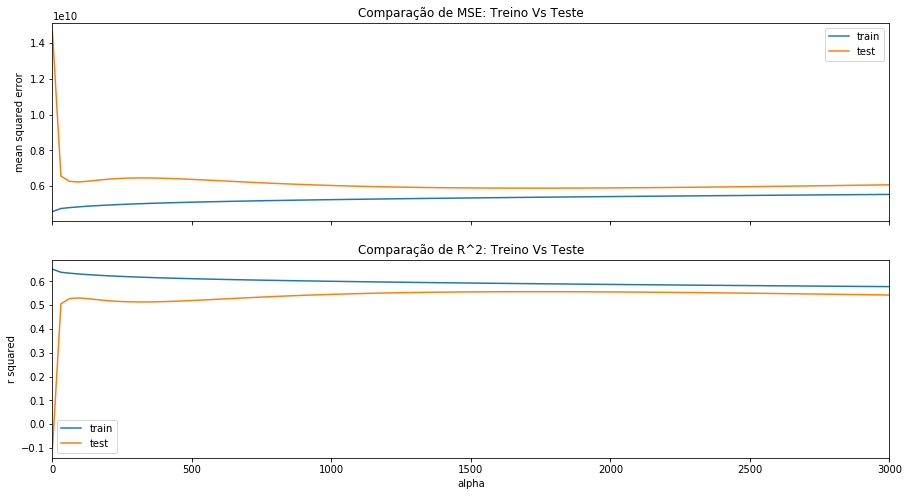

In [31]:
plot_comparison(alpha_list, mse_tr_list, mse_te_list, r2_tr_list, r2_te_list)

## C)  Avaliação dos Parâmetros

A principal característica da regularização é a diminuição gradual da magnitude dos pesos a cada iteração. Essa diminuição controla o tamanho máximo dos parâmetros internos do modelo, impedindo que os mesmos definam espaços de solução muito irregulares, o que pode levar a soluções não genéricas.

Nessa seção serão comparados os parâmetros treinados com **regularização L1**. Os valores de ${alpha}$ utilizados serão definidos a partir do estudo realizado no item B.

### Função Auxiliar

A função abaixo treina um dado modelo linear por `max_iter` épocas, armazenando o histórico de cada parâmetro.

In [32]:
def train_model(model_class, X, y, max_iter, **kwargs):
    
    def get_params(model, X, y, iter):        
        model.fit(X, y)
        return pd.DataFrame(
            index=[iter],
            columns=X.columns.tolist() + ["intercept"],
            data=[model.coef_.tolist() + [model.intercept_]]
        )
    
    model = model_class(warm_start=True, max_iter=1, **kwargs)
    params = get_params(model, X, y, 0)
    for iter in range(1, max_iter):        
        params = params.append(get_params(model, X, y, iter))
    return params

### Dados utilizados

Para facilitar a visualização da evolução dos pesos a cada iteração, será utilizada apenas uma amostra das features disponíveis. O número recomendável de features é de até 15; acima disso, fica difícil distinguir as cores de cada feature.

In [33]:
features = [
    'log_of_total_rooms', 
    'log_of_total_bedrooms', 
    'log_of_population',
    'log_of_households', 
    'log_of_median_income',
    'total_rooms', 
    'total_bedrooms', 
    'population',
    'households', 
    'median_income'
]

In [34]:
X = x_train[features]
y = y_train

### Valor de ${alpha}$ próximo a zero

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


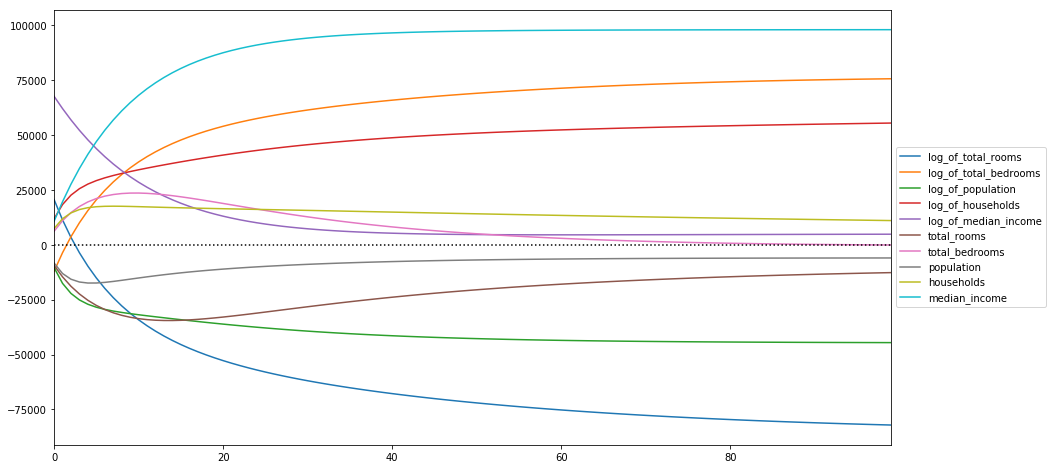

In [35]:
""" Escreva a solução aqui """
train_model(Lasso, X, y, 100, alpha=0.1).plot(figsize=(15,8))
plt.plot((0, 100), (0, 0), "k:")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Valor de ${alpha}$ mediano

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


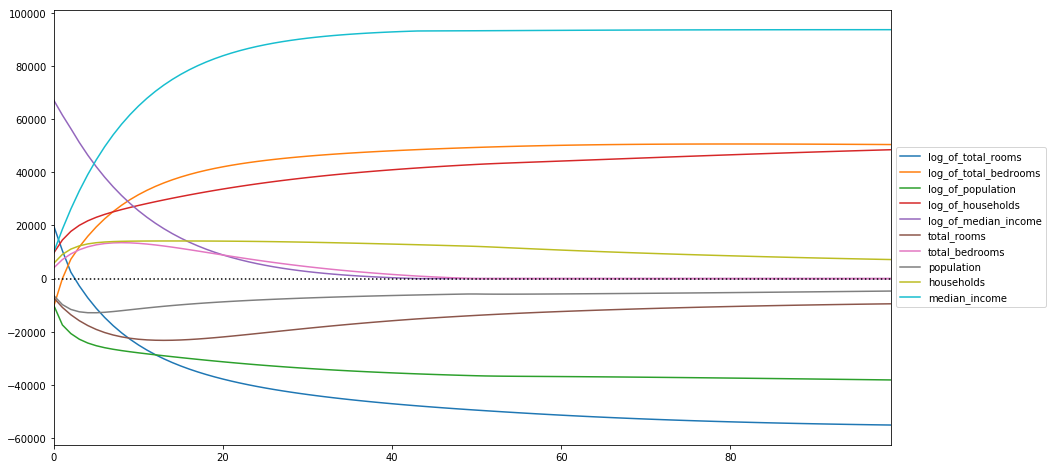

In [36]:
""" Escreva a solução aqui """
train_model(Lasso, X, y, 100, alpha=1000).plot(figsize=(15,8))
plt.plot((0, 100), (0, 0), "k:")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Valor de ${alpha}$ alto

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


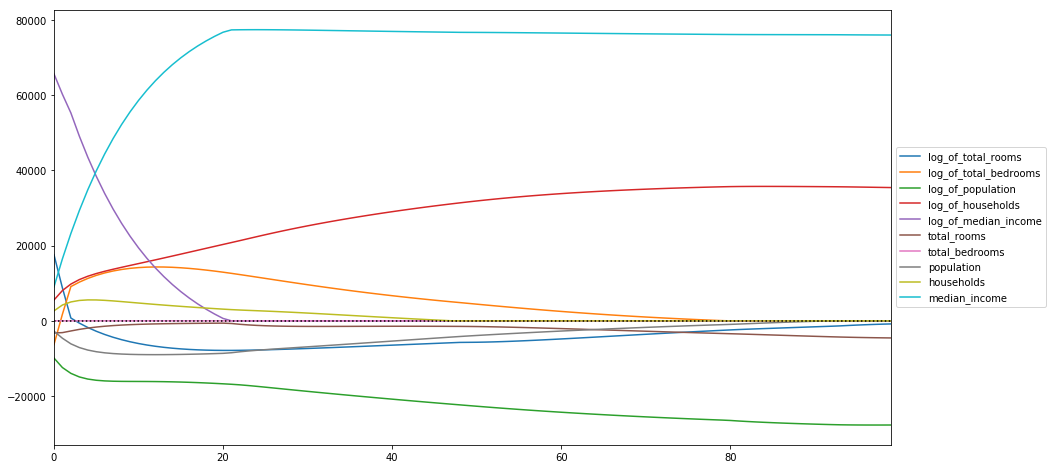

In [37]:
""" Escreva a solução aqui """
train_model(Lasso, X, y, 100, alpha=3000).plot(figsize=(15,8))
plt.plot((0, 100), (0, 0), "k:")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))